## Narzędzie graficzne

In [1]:
import math
import matplotlib.tri as tri

import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import pandas as pd

TOLERANCE = 0.20

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
               
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
          
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points
        
    def get_points(self):
        return self.points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]

    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        
%matplotlib notebook

In [3]:
def get_points_from_plot(plot):
        points = [] 
        lines = plot.get_added_figure()[0].lines
        for line in lines:
            points.append(line[0])
        return points
def points_to_lines(points):
    lines = []
    for i in range(len(points)):
        lines.append((points[i-1],points[i]))
    return lines

<IPython.core.display.Javascript object>


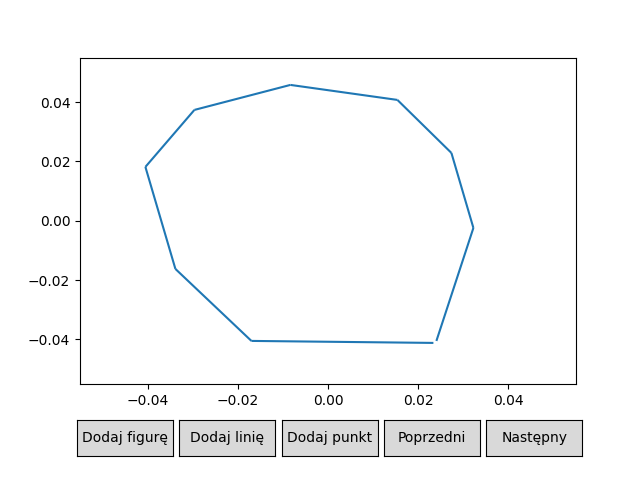

In [47]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [48]:
data1=get_points_from_plot(plot)

<IPython.core.display.Javascript object>


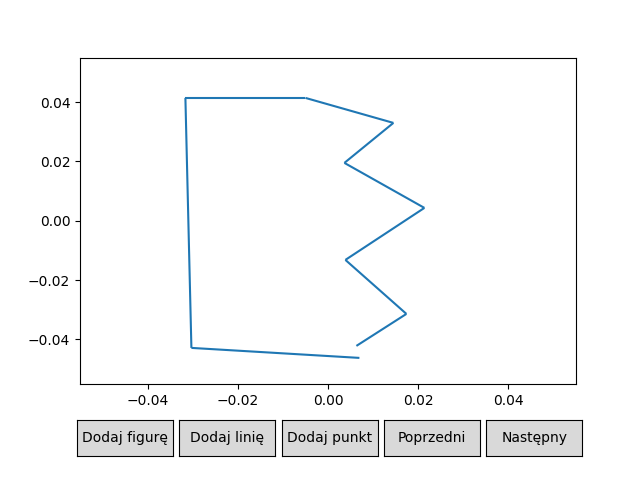

In [6]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [7]:
data2 = get_points_from_plot(plot)

<IPython.core.display.Javascript object>


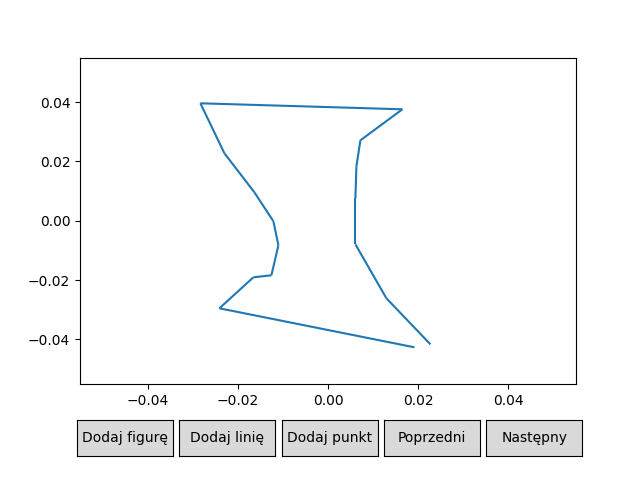

In [8]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [9]:
data3 = get_points_from_plot(plot)

<IPython.core.display.Javascript object>


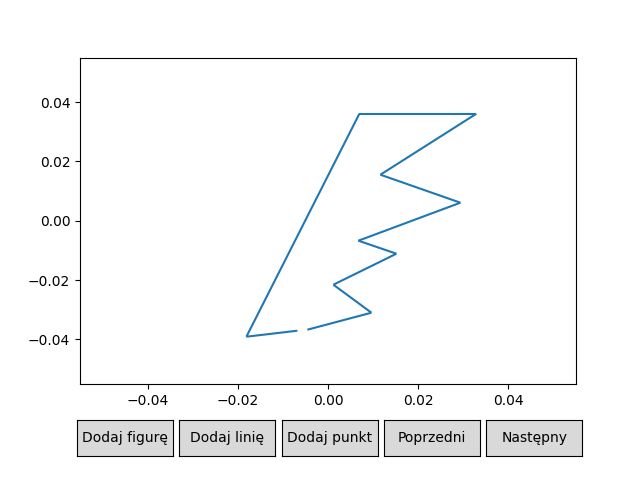

In [10]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [11]:
data4 = get_points_from_plot(plot)

<IPython.core.display.Javascript object>


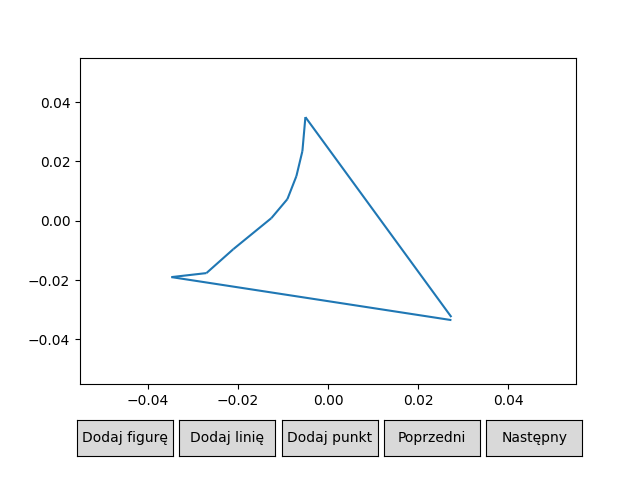

In [12]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [13]:
data5 = get_points_from_plot(plot)

In [4]:
def save_to_csv(data, name):
    df = pd.DataFrame()
    df['Points']=data
    df.to_csv(name, index=False)

In [5]:
def get_points_from_csv(name):
    result=[]
    data=pd.read_csv(name)
    for line in data['Points']:
        line = line.replace("(","")
        line = line.replace(")","")
        line = line.split(", ")
        result.append((float(line[0]),float(line[1])))
    return result

## Zapis punktów do CSV

In [34]:
save_to_csv(data1,"Punkty_1.csv")
save_to_csv(data2,"Punkty_2.csv")
save_to_csv(data3,"Punkty_3.csv")
save_to_csv(data4,"Punkty_4.csv")
save_to_csv(data5,"Punkty_5.csv")

## Pobieranie punktów z CSV

In [6]:
data1=get_points_from_csv("Punkty_1.csv")
data2=get_points_from_csv("Punkty_2.csv")
data3=get_points_from_csv("Punkty_3.csv")
data4=get_points_from_csv("Punkty_4.csv")
data5=get_points_from_csv("Punkty_5.csv")

In [7]:
def maxY_index(points):
    maximum=float('-inf')
    index=-1
    for i in range(len(points)):
        if points[i][1]>maximum:
            maximum=points[i][1]
            index=i
    return index

def minY_index(points):
    minimum=float('inf')
    index=-1
    for i in range(len(points)):
        if points[i][1]<minimum:
            minimum=points[i][1]
            index=i
    return index

def yMonotony(points):
    top=maxY_index(points)
    bottom=minY_index(points)
    i=top
    while i != bottom:
        next_point=(i+1)%len(points)
        if points[next_point][1]>points[i][1]:
            return False       
        i=next_point
    i=bottom
    
    i=bottom
    while i != top:
        next_point=(i+1)%len(points)
        if points[next_point][1]<points[i][1]:
            return False       
        i=next_point
        
    return True

In [8]:
epsilon = 10**(-12)
def matrix_2x2(a,b,c):
    return [[a[0]-c[0], a[1]-c[1]], [ b[0]-c[0], b[1]-c[1]]]

def det_2x2(a,b,c):
    matrix=matrix_2x2(a,b,c)
    return (matrix[0][0]*matrix[1][1])-(matrix[0][1]*matrix[1][0])

def is_in_polygon(a,b,c, number):
    if number == 0:
        return det_2x2(a,b,c) > epsilon
    else:
        return det_2x2(a,b,c) <- epsilon

# Triangulacja z ćwiczeń

In [9]:
def triangulation(points):
    if not yMonotony(points):
        print("Wielokat nie jest y-monotoniczny")
        return None, None
    
    maximum_index = maxY_index(points)
    minimum_index = minY_index(points)
    
    specified_points= []
    i=maximum_index
    while i!=minimum_index:
        specified_points.append((points[i],0,i))
        i=(i+1)%len(points)
    while i!=maximum_index:
        specified_points.append((points[i],1,i))
        i=(i+1)%len(points)
    specified_points.sort(reverse = True, key = lambda x: x[0][1])
    
    diagonals = []
    stack = []
    scenes = []
    diagonal_index=[]
    
    stack.append(specified_points[0])
    stack.append(specified_points[1])
    diagonals.append([specified_points[0][0], specified_points[1][0]])
    diagonal_index.append((specified_points[0][2],specified_points[1][2]))
 
    scenes.append(Scene([PointsCollection(points), PointsCollection([specified_points[0][0]], color="red", marker="D")], [LinesCollection(diagonals.copy(), color="black")]))    
    scenes.append(Scene([PointsCollection(points), PointsCollection([specified_points[1][0]], color="red", marker="D")], [LinesCollection(diagonals.copy(), color="black")]))
    
    for i in range(2, len(specified_points)):
        if stack[-1][1] != specified_points[i][1]:
            while len(stack) > 0:
                new_verticle = stack.pop()
                diagonals.append([new_verticle[0], specified_points[i][0]])
                diagonal_index.append((new_verticle[2],specified_points[i][2]))
                scenes.append(Scene([PointsCollection(points), PointsCollection([specified_points[i][0]], color="red", marker="D")], [LinesCollection(diagonals.copy(), color="black")]))
            stack.append(specified_points[i-1])
            stack.append(specified_points[i])
        else:
            new_verticle = stack.pop()
            diagonals.append([specified_points[i][0], new_verticle[0]])
            diagonal_index.append((specified_points[i][2],new_verticle[2]))
            scenes.append(Scene([PointsCollection(points), PointsCollection([specified_points[i][0]], color="red", marker="D")], [LinesCollection(diagonals.copy(), color="black")]))
            while len(stack) > 0 and is_in_polygon(specified_points[i][0], stack[-1][0], new_verticle[0], specified_points[i][1]):
                new_verticle = stack.pop()
                diagonals.append([new_verticle[0], specified_points[i][0]])
                diagonal_index.append((new_verticle[2], specified_points[i][2]))
                scenes.append(Scene([PointsCollection(points), PointsCollection([specified_points[i][0]], color="red", marker="D")], [LinesCollection(diagonals.copy(), color="black")]))
            stack.append(new_verticle)
            stack.append(specified_points[i])
  
    final_scene = Scene([PointsCollection(points)], [LinesCollection(diagonals.copy(), color="black")])
    scenes = [final_scene] + scenes
                        
    return diagonal_index, scenes

<IPython.core.display.Javascript object>


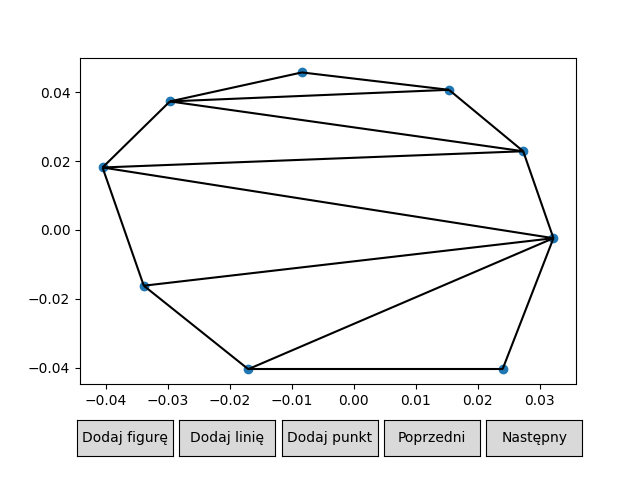

In [10]:
_, data = triangulation(data1)
plot = Plot(data)
plot.draw()

<IPython.core.display.Javascript object>


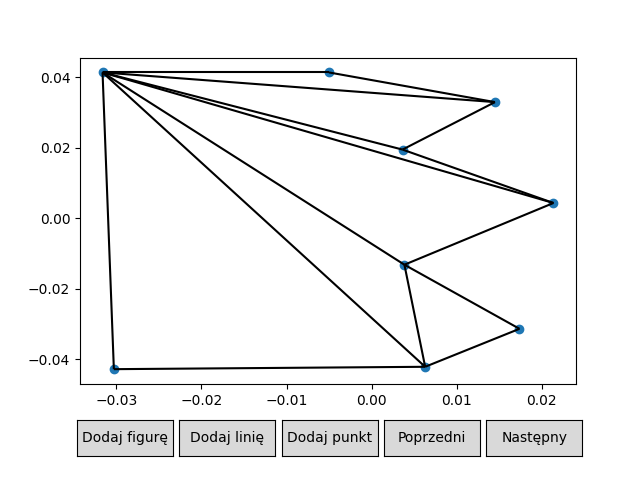

In [11]:
_, data = triangulation(data2)
plot = Plot(data)
plot.draw()

<IPython.core.display.Javascript object>


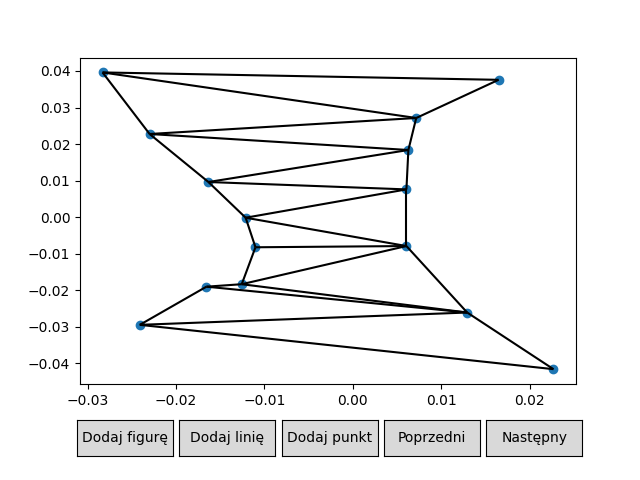

In [12]:
_, data = triangulation(data3)
plot = Plot(data)
plot.draw()

<IPython.core.display.Javascript object>


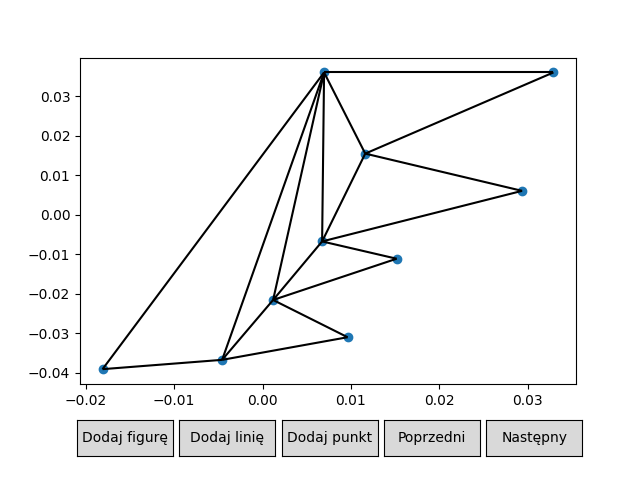

In [13]:
_ , data = triangulation(data4)
plot = Plot(data)
plot.draw()

<IPython.core.display.Javascript object>


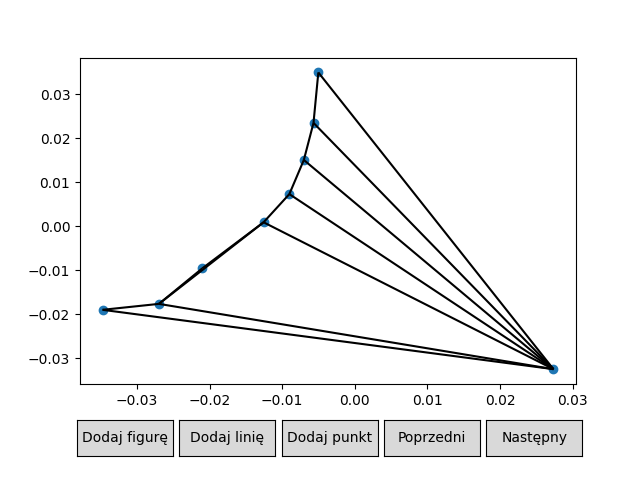

In [14]:
_ , data = triangulation(data5)
plot = Plot(data)
plot.draw()

# Triangulacja Delaunay'a

<IPython.core.display.Javascript object>


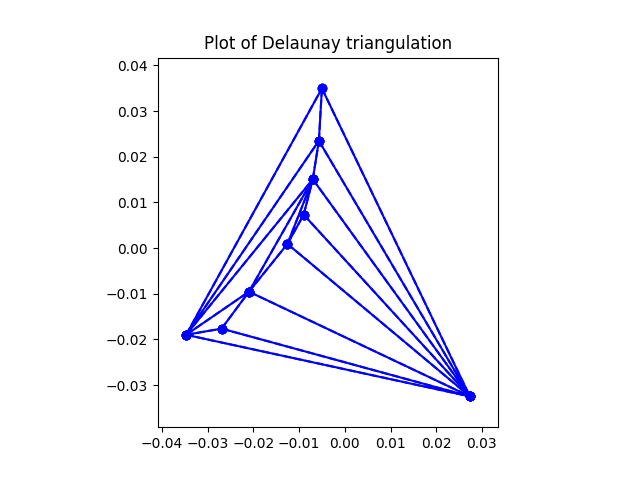

In [14]:
def SharedEdge(line1, line2):
    if (line1[0] == line2[0] and line1[1] == line2[1]) or (line1[0] == line2[1] and line1[1] == line2[0]):
        return True
    return False


class Point:
    def __init__(self, x, y, z=0):
        self.x = x
        self.y = y
        self.z = z

    def __repr__(s):
        return "( " + str(s.x) + ", " + str(s.y) + " )"

    def __add__(self, b):
        return Point(self.x + b.x, self.y + b.y)

    def __sub__(self, b):
        return Point(self.x - b.x, self.y - b.y)

    def __mul__(self, b):
        return Point(b * self.x, b * self.y)

    __rmul__ = __mul__

    def IsInCircumcircleOf(self, T):

        a_x = T.v[0].x
        a_y = T.v[0].y

        b_x = T.v[1].x
        b_y = T.v[1].y

        c_x = T.v[2].x
        c_y = T.v[2].y

        # The point coordinates

        d_x = self.x
        d_y = self.y

        # If the following determinant is greater than zero then point lies inside circumcircle
        incircle = np.array([[a_x - d_x, a_y - d_y, (a_x - d_x) ** 2 + (a_y - d_y) ** 2],
                             [b_x - d_x, b_y - d_y, (b_x - d_x) ** 2 + (b_y - d_y) ** 2],
                             [c_x - d_x, c_y - d_y, (c_x - d_x) ** 2 + (c_y - d_y) ** 2]])

        if np.linalg.det(incircle) > 0:
            return True
        else:
            return False


class Triangle:
    def __init__(self, a, b, c):
        self.v = [None] * 3
        self.v[0] = a
        self.v[1] = b
        self.v[2] = c

        self.edges = [[self.v[0], self.v[1]],
                      [self.v[1], self.v[2]],
                      [self.v[2], self.v[0]]]

        self.neighbour = [None] * 3

    def HasVertex(self, point):
        if (self.v[0] == point) or (self.v[1] == point) or (self.v[2] == point):
            return True
        return False

    def __repr__(s):
        '''
        return '<%s, [%s, %s, %s]>' % (
                hex(id(s)),
                hex(id(s.neighbour[0])),
                hex(id(s.neighbour[1])),
                hex(id(s.neighbour[2])))
        '''
        return '< ' + str(s.v) + ' >'


class Delaunay_Triangulation:
    def __init__(self, WIDTH, HEIGHT):
        self.triangulation = []

        # Declaring the super triangle coordinate information
        self.SuperPointA = Point(-100, -100)
        self.SuperPointB = Point(2 * WIDTH + 100, -100)
        self.SuperPointC = Point(-100, 2 * HEIGHT + 100)

        superTriangle = Triangle(self.SuperPointA, self.SuperPointB, self.SuperPointC)

        self.triangulation.append(superTriangle)

    def AddPoint(self, p):

        bad_triangles = []

        for triangle in self.triangulation:
            # Check if the given point is inside the circumcircle of triangle
            if p.IsInCircumcircleOf(triangle):
                # If it is then add the triangle to bad triangles
                bad_triangles.append(triangle)

        polygon = []

        # Routine is to find the convex hull of bad triangles
        # This involves a naive search method, which increases the time complexity
        for current_triangle in bad_triangles:
            for this_edge in current_triangle.edges:
                isNeighbour = False
                for other_triangle in bad_triangles:
                    if current_triangle == other_triangle:
                        continue
                    for that_edge in other_triangle.edges:
                        if SharedEdge(this_edge, that_edge):
                            # Check if the Edge is shared between two triangles
                            # If the edge is shared it won't be included into the convex hull
                            isNeighbour = True
                if not isNeighbour:
                    polygon.append(this_edge)

        # Delete the bad triangles
        for each_triangle in bad_triangles:
            self.triangulation.remove(each_triangle)

        # Re-triangle the convex hull using the given point
        for each_edge in polygon:
            newTriangle = Triangle(each_edge[0], each_edge[1], p)
            self.triangulation.append(newTriangle)

    def Remove_Super_Triangles(self):
        # Removing the super triangle using Lamba function
        onSuper = lambda triangle: triangle.HasVertex(self.SuperPointA) or triangle.HasVertex(
            self.SuperPointB) or triangle.HasVertex(self.SuperPointC)

        for triangle_new in self.triangulation[:]:
            if onSuper(triangle_new):
                self.triangulation.remove(triangle_new)

    def export(self):

        ps = [p for t in self.triangulation for p in t.v]

        x_s = [p.x for p in ps]
        y_s = [p.y for p in ps]

        # xs = list(set(xs))
        # ys = list(set(ys))

        ts = [(ps.index(t.v[0]), ps.index(t.v[1]), ps.index(t.v[2])) for t in self.triangulation]

        return x_s, y_s, ts

    def Find_Neighbours(self):
        # Function to find the neighbours of the Delaunay triangles
        for one in self.triangulation:
            edge = 0
            for this_edge in one.edges:
                edge = (edge + 1) % 3
                for other in self.triangulation:
                    if one == other:
                        continue
                    for that_edge in other.edges:
                        if SharedEdge(this_edge, that_edge):
                            one.neighbour[edge] = other

                            # Simple delaunay triangle generator
# Implementation of incremental Bowyer-Watson Algorithm
# This has a time complexity of O(n^2)
# Refer to the Wikipedia page of Bowyer watson algorithm as I have implemented directly from the Pseudo-code

# Author: Vignesh Rajendiran

# This is written with ease of understanding in mind. If you want elaborate code. Then visit https://github.com/ayron
# I referred to Ayrons code for inspiration. I am planning to rewrite this code as my own in the future.

# sometimes there will be a cross division error if the n>100 because of random points used and WIDTH, HEIGHT values

# WIDTH = int(100)
# HEIGHT = int(100)
# n = 21  # n should be greater than 2

maximum=-float('inf')
minimum=float('inf')
for line in data5:
    maximum=max(line[0],line[1],maximum)
    minimum=min(line[0],line[1],minimum)

WIDTH = maximum-minimum
HEIGHT = maximum-minimum
n=len(data5)

# xs = [random.randint(1, WIDTH - 1) for x in range(n)]
# ys = [random.randint(1, HEIGHT - 1) for y in range(n)]
# zs = [0 for z in range(n)]

xs = [x[0] for x in data5]
ys = [y[1] for y in data5]
zs = [0 for z in range(n)]

DT = Delaunay_Triangulation(WIDTH, HEIGHT)

# for x, y in zip(xs, ys):
#     DT.AddPoint(Point(x, y))

for p in data5:
    DT.AddPoint(Point(p[0],p[1]))

# Remove the super triangle on the outside
DT.Remove_Super_Triangles()

# Helps in determining the neighbours of triangles. I felt it might help in the future
# Remove this to speed up triangle generation
# DT.Find_Neighbours()

XS, YS, TS = DT.export()

# Creating a Triangulation without specifying the triangles results in the
# Delaunay triangulation of the points.

# Create the Triangulation; no triangles so Delaunay triangulation created.
triang = tri.Triangulation(xs, ys)

# Plot the triangulation.
fig, ax = plt.subplots()
ax.margins(0.1)
ax.set_aspect('equal')
ax.triplot(triang, 'bo-')

# print(XS)
# print(YS)
# print(TS)

ax.triplot(tri.Triangulation(XS, YS, TS), 'bo--')
ax.set_title('Plot of Delaunay triangulation')

plt.show()
